In [75]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None) 

In [4]:
df = pd.read_csv('casestudy.csv')
df.sample(5)

,Unnamed: 0,customer_email,net_revenue,year
371749,371749,ejaikwfkyn@gmail.com,143.76,2016
485832,485832,qedzykfjdp@gmail.com,198.48,2017
220548,220548,ruszibjlna@gmail.com,49.85,2015
237182,237182,iglpfurygw@gmail.com,104.83,2016
626205,626205,tnuehutnny@gmail.com,85.43,2017


In [60]:
df.describe()

,Unnamed: 0,net_revenue,year
count,685927.000000,685927.000000,685927.000000
mean,342963.000000,125.647755,2016.027252
std,198010.213384,71.854528,0.837203
min,0.000000,1.000000,2015.000000
25%,171481.500000,63.510000,2015.000000
50%,342963.000000,125.730000,2016.000000
75%,514444.500000,187.820000,2017.000000
max,685926.000000,250.000000,2017.000000


We can see that, there are 685927 rows in the dataset which are distributed in year 2015, 2016 and 2017. In order to make the answer logically readable, they are not presented in the order the same as questions.

## Total revenue

In [67]:
total_rev = df.groupby('year').sum().drop(['Unnamed: 0'], axis=1)
total_rev.columns = ['total_revenue']
total_rev

,total_revenue
year,
2015,29036749.19
2016,25730943.59
2017,31417495.03


## Total Customers Current Year

In [68]:
total_cus = df[['year', 'Unnamed: 0']].drop_duplicates(subset=['Unnamed: 0']).groupby('year').count()
total_cus.columns = ['total_customers']
total_cus

,total_customers
year,
2015,231294
2016,204646
2017,249987


In [27]:
# df[['year', 'Unnamed: 0']].groupby('year').count()
# There are no duplicates

## Total Customers Previous Year

In [69]:
pre_cus = df[['year', 'Unnamed: 0']].drop_duplicates(subset=['Unnamed: 0']).groupby('year').count().shift(1)
pre_cus.columns = ['previous_customers']
pre_cus

,previous_customers
year,
2015,NaN
2016,231294.0
2017,204646.0


## New Customers & Revenue
Here, we define a new customer as a customer that not appears in the last year only.

In [53]:
new_cus = pd.DataFrame(data = None,columns = ['new_customers', 'new_revenue'])
for i in df['year'].drop_duplicates():
    if i == 2015:
        new_num = len(df[df.year == i])
        new_rev = df[df.year == 2015]['net_revenue'].sum()
        new_cus.loc[i, 'new_customers'] = new_num
        new_cus.loc[i, 'new_revenue'] = new_rev
    else:
        previous = df.loc[df.year == i-1]
        current = df.loc[df.year == i]
        new_num = len(current.loc[current.customer_email.isin(previous.customer_email) == False])
        new_rev = current.loc[current.customer_email.isin(previous.customer_email) == False]['net_revenue'].sum()
        new_cus.loc[i, 'new_customers'] = new_num
        new_cus.loc[i, 'new_revenue'] = new_rev
        
new_cus.index.name='year'
new_cus

,new_customers,new_revenue
year,,
2015,231294,29036749.19
2016,145062,18245491.01
2017,229028,28776235.04


## Lost Customers & Revenue Lost from Attrition
Here, we define a lost customer as a customer that appears in the last year but not in this year.

In [51]:
lost_cus = pd.DataFrame(data = None,columns = ['lost_customers', 'lost_revenue'])
for i in df['year'].drop_duplicates():
    if i == 2015:
        lost_cus.loc[i, 'lost_customers'] = None
        lost_cus.loc[i, 'lost_revenue'] = None
    else:
        previous = df.loc[df.year == i-1]
        current = df.loc[df.year == i]
        lost_num = len(previous.loc[previous.customer_email.isin(current.customer_email) == False])
        lost_rev = previous.loc[previous.customer_email.isin(current.customer_email) == False]['net_revenue'].sum()
        lost_cus.loc[i, 'lost_customers'] = lost_num
        lost_cus.loc[i, 'lost_revenue'] = lost_rev
        
lost_cus.index.name = 'year'
lost_cus

,lost_customers,lost_revenue
year,,
2015,None,None
2016,171710,21571632.07
2017,183687,23110294.94


## Existing Customer Revenue & Growth
Here, we define an existing customer as a customer that appears both in the last year and in this year.

In [117]:
exi_cus = pd.DataFrame(data = None,columns = ['existing_customers', 'existing_revenue', 'prior_revenue', 'growth'])
for i in df['year'].drop_duplicates():
    if i == 2015:
        exi_num = len(df[df.year == i])
        exi_rev = df[df.year == 2015]['net_revenue'].sum()
        exi_cus.loc[i, 'existing_customers'] = 0
        exi_cus.loc[i, 'existing_revenue'] = 0
        exi_cus.loc[i, 'prior_revenue'] = 0
        exi_cus.loc[i, 'growth'] = 0
    else:
        previous = df.loc[df.year == i-1]
        current = df.loc[df.year == i]
        exi_cur = current.loc[current.customer_email.isin(previous.customer_email) == True]
        exi_pri = previous.loc[previous.customer_email.isin(current.customer_email) == True]
        exi_num = len(exi_cur)
        exi_rev = exi_cur['net_revenue'].sum()
        pri_rev = exi_pri['net_revenue'].sum()
        exi_cus.loc[i, 'existing_customers'] = exi_num
        exi_cus.loc[i, 'existing_revenue'] = exi_rev
        exi_cus.loc[i, 'prior_revenue'] = pri_rev
        exi_cus.loc[i, 'growth'] = exi_rev - pri_rev
        
exi_cus.index.name='year'
exi_cus

,existing_customers,existing_revenue,prior_revenue,growth
year,,,,
2015,0,0,0,0
2016,59584,7485452.58,7465117.12,20335.46
2017,20959,2641259.99,2620648.65,20611.34


Now we join up all results into one data frame.

In [118]:
res = pd.concat([total_rev, total_cus, pre_cus, new_cus, lost_cus, exi_cus], axis = 1)
res

,total_revenue,total_customers,previous_customers,new_customers,new_revenue,lost_customers,lost_revenue,existing_customers,existing_revenue,prior_revenue,growth
year,,,,,,,,,,,
2015,29036749.19,231294,NaN,231294,29036749.19,None,None,0,0,0,0
2016,25730943.59,204646,231294.0,145062,18245491.01,171710,21571632.07,59584,7485452.58,7465117.12,20335.46
2017,31417495.03,249987,204646.0,229028,28776235.04,183687,23110294.94,20959,2641259.99,2620648.65,20611.34


<Figure size 432x288 with 0 Axes>

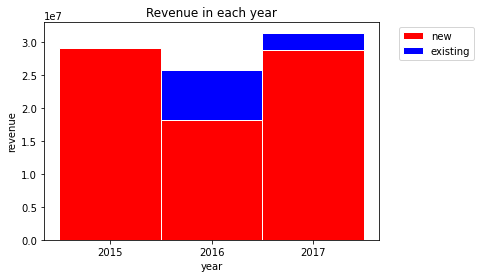

In [119]:
fig=plt.figure('Revenue')
labels = ['2015', '2016', '2017']
width=1
fig, ax1=plt.subplots()
ax1.bar(labels, res.new_revenue, width, color='red', edgecolor='white', label='new')
ax1.bar(labels, res.existing_revenue, width, bottom=res.new_revenue, color='blue', edgecolor='white', label='existing')
plt.title('Revenue in each year')
plt.xlabel('year')
plt.ylabel('revenue')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
# plt.show()

From the plot, we can see that total revenue in 2017 is the highest and that in 2016 is the lowest. Most of the revenue comes from new customers.

<Figure size 432x288 with 0 Axes>

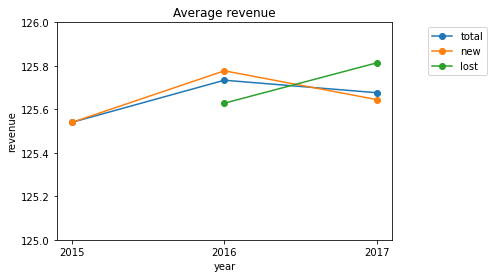

In [135]:
fig=plt.figure('Revenue')
labels = ['2015', '2016', '2017']
fig, ax1=plt.subplots()
ax1.plot(labels, res.total_revenue/res.total_customers, marker='o', label='total')
ax1.plot(labels, res.new_revenue/res.new_customers, marker='o', label='new')
ax1.plot(labels, res.lost_revenue/res.lost_customers, marker='o', label='lost')
plt.title('Average revenue')
plt.ylim((125, 126))
plt.xlabel('year')
plt.ylabel('revenue')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
# plt.show()

We can see that the average revenue remains stable regardless of year and customer type.